# 10_arc_slice

#### -> sampling 3D CT by pre-defined parabola

In [ ]:
import numpy as np
from scipy.ndimage.interpolation import rotate as rot3d

import matplotlib.pyplot as plt
import math
import time

In [ ]:
## load np ct data
root = 'C://Users//Heeguen//Desktop//heeguen//Dental_panorama_2020/np_data/'

sam = np.load(root+'register_ct.npy')

sam_tmp = sam[0][..., :220]
print(sam_tmp.shape)

In [3]:
## take sample, projection to width-height plane
sam_ = np.zeros((sam_tmp.shape))
val = sam_tmp.min()

for s in range(sam_tmp.shape[2]):
    for w in range(sam_tmp.shape[0]):
        for h in range(sam_tmp.shape[1]):
            sam_[w, h, s] = sam_tmp[w, h, s] - val
            
sum_ = np.sum(sam_, axis=2) # projection to 2d
print(sam_.min())
print(sum_.shape)

0.0
(671, 671)


Text(0.5, 0, 'parabola function + 2d ct image')

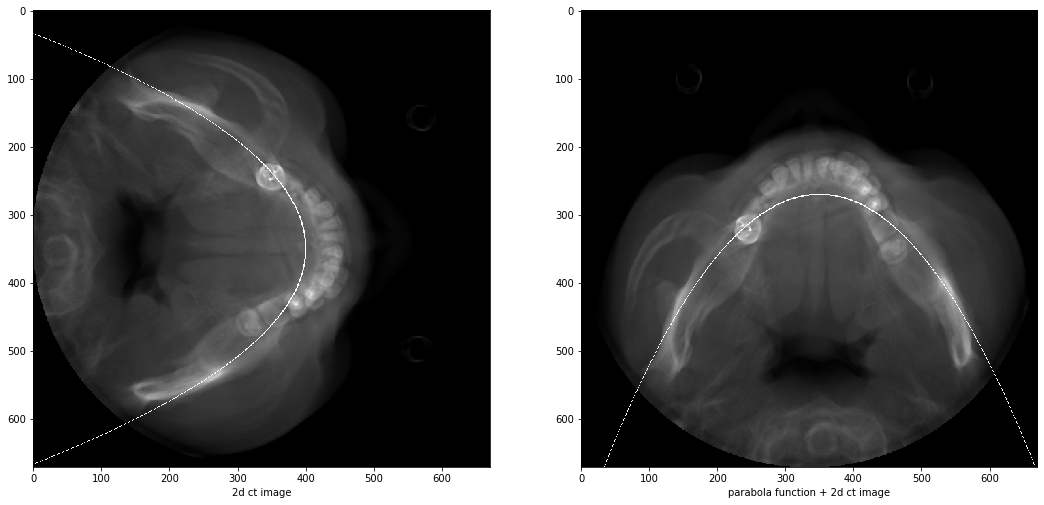

In [4]:
## x, y meshgrid
x = np.zeros((671, 671))
y = np.zeros((671, 671))

for w in range(x.shape[0]):
    for h in range(x.shape[1]):
        x[w,h] = h
        y[w,h] = w      

## make parabola function and apply to projected 2d ct image
a = 0.004
b = 350
c = 400

tmp = abs(-a*(y-b)**2+c-x)
tmp_ = np.where(tmp < 1, sum_.max() + 100, sum_)
rot = rot3d(tmp_, 90, axes=(1,0), reshape=False) # test rotation

# test -> plot
## plot projected 2d ct image (1) and projected 2d ct image with parabola function (2)
plt.figure(figsize=(18,9))
plt.subplot(121)
plt.xlabel('2d ct image')
plt.imshow(tmp_, cmap='gray')

plt.subplot(122)
plt.imshow(rot, cmap='gray')
plt.xlabel('parabola function + 2d ct image')

In [33]:
## capturing by 4 conditions (x(p)와 y(q)값의 변화량을 고려)
program_starts = time.time()

p=150
q=round(math.sqrt(-(p-c)/a)+b) # 600
delta_x = 1
delta_y = 0
img_pano = []
w_img_pano = []
i=1

while (p <= c) and (delta_x >= delta_y) :
    loop_starts = time.time()
#     if p <= c and delta_x >= delta_y:
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
    
    # rotate 3d
    ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
    sample = ct_vol[:, indx[0][0], :]

    # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
    weighted_sample = np.zeros((sample.shape[0], sample.shape[1]))
    
    for w in range(sample.shape[0]):
        weighted_sample[w] = sample[w]*(1-(w/sample.shape[0]))

    sum_ct_vol = np.sum(sample, axis=0) # no magnification factor
    w_sum = np.sum(weighted_sample, axis=0) # add magnification factor

    img_pano.append(np.reshape(sum_ct_vol, (ct_vol.shape[2], 1)))
    w_img_pano.append(np.reshape(w_sum, (ct_vol.shape[2], 1)))

    prev_p=p
    prev_q=q
    p=p+1
    q=round(math.sqrt(-(p-c)/a)+b)
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    p_indx = indx[0][0]

    print(i, 'angle : ', angle)
    print('1번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    
    i+=1
    if i <= 10 : 
        now = time.time()
        print("Takes {0} seconds for 1 loop".format(now - loop_starts))
        
    print('==========================================')
    
while (q>=b):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)
    
    if g != 0:
        tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
        tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
        rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
        sum_rot_tmp = np.sum(rot_tmp, axis=0)
        indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
        
        if indx[0][0] > p_indx + 10 :
            indx[0][0] = p_indx 

        ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
        sample = ct_vol[:, indx[0][0], :]
        
        # magnification factor 0~500 pixel = 0 ~ 1 
        weighted_sample = np.zeros((sample.shape[0], sample.shape[1]))
        
        for w in range(sample.shape[0]):
            weighted_sample[w] = sample[w]*(1-(w/sample.shape[0])) 

        sum_ct_vol = np.sum(sample, axis=0) # no magnification factor
        w_sum = np.sum(weighted_sample, axis=0) # add magnification factor
        
        img_pano.append(np.reshape(sum_ct_vol, (ct_vol.shape[2], 1)))
        w_img_pano.append(np.reshape(w_sum, (ct_vol.shape[2], 1)))
        
    else:
        print(angle, ' (degree)')
        tmp = abs((y-q)) ### 90도 일때 , 법선을 따로 구해줘야함. 
        tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)  
        rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False)
        sum_rot_tmp = np.sum(rot_tmp, axis=0)
        indx = np.where(sum_rot_tmp == sum_rot_tmp.max())

        ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
        sample = ct_vol[:, indx[0][0], :]
        
        # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
        weighted_sample = np.zeros((sample.shape[0], sample.shape[1]))
        
        for w in range(sample.shape[0]):
            weighted_sample[w] = sample[w]*(1-(w/sample.shape[0]))

        sum_ct_vol = np.sum(sample, axis=0) # no magnification factor
        w_sum = np.sum(weighted_sample, axis=0) # add magnification factor
        
        img_pano.append(np.reshape(sum_ct_vol, (ct_vol.shape[2], 1)))
        w_img_pano.append(np.reshape(w_sum, (ct_vol.shape[2], 1)))
    
    prev_p=p
    prev_q=q
    q=q-1
    p=(-a)*(q-b)**2+c
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    p_indx = indx[0][0]
    
    print(i, 'angle : ', angle)
    print('2번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    print('==========================================')
    i=i+1
    
while (q>=150) and (delta_x<=delta_y):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
    
    if indx[0][0] > p_indx + 10 :
        indx[0][0] = p_indx 

    ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
    sample = ct_vol[:, indx[0][0], :]

    # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
    weighted_sample = np.zeros((sample.shape[0], sample.shape[1]))
    
    for w in range(sample.shape[0]):
        weighted_sample[w] = sample[w]*(1-(w/sample.shape[0]))

    sum_ct_vol = np.sum(sample, axis=0) # no magnification factor
    w_sum = np.sum(weighted_sample, axis=0) # add magnification factor

    img_pano.append(np.reshape(sum_ct_vol, (ct_vol.shape[2], 1)))
    w_img_pano.append(np.reshape(w_sum, (ct_vol.shape[2], 1)))
    
    prev_p=p
    prev_q=q
    q=q-1
    p=-a*(q-b)**2+c
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    
    print(i, 'angle : ', angle)
    print('3번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    print('==========================================')
    i=i+1
    
while (p>=150):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())

    ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
    sample = ct_vol[:, indx[0][0], :]

    # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
    weighted_sample = np.zeros((sample.shape[0], sample.shape[1]))
    
    for w in range(sample.shape[0]):
        weighted_sample[w] = sample[w]*(1-(w/sample.shape[0]))

    sum_ct_vol = np.sum(sample, axis=0) # no magnification factor
    w_sum = np.sum(weighted_sample, axis=0) # add magnification factor

    img_pano.append(np.reshape(sum_ct_vol, (ct_vol.shape[2], 1)))
    w_img_pano.append(np.reshape(w_sum, (ct_vol.shape[2], 1))) 
    
    prev_p=p
    prev_q=q
    p=p-1 
#     q=round(math.sqrt(-(p-c)/a)+b) ->  q=round(-math.sqrt(-(p-c)/a)+b) 그래프가 뒤집어 져야함. (수정)
    q=round(-math.sqrt(-(p-c)/a)+b)

    print(i, 'angle : ', angle)
    print('4번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    print('==========================================')
    i=i+1

    
now = time.time()
print("Total loop : ",(now - program_starts)/60, " min")

1 angle :  153.43494882292202
1번 조건문
prev_p :  150 prev_q :  600
delta x and delta y :  1 1
Takes 11.563776969909668 seconds for 1 loop
2 angle :  153.34298135854587
1번 조건문
prev_p :  151 prev_q :  599
delta x and delta y :  1 0
Takes 11.442632913589478 seconds for 1 loop
3 angle :  153.34298135854587
1번 조건문
prev_p :  152 prev_q :  599
delta x and delta y :  1 1
Takes 11.462530374526978 seconds for 1 loop
4 angle :  153.2504219906605
1번 조건문
prev_p :  153 prev_q :  598
delta x and delta y :  1 0
Takes 11.446468830108643 seconds for 1 loop
5 angle :  153.2504219906605
1번 조건문
prev_p :  154 prev_q :  598
delta x and delta y :  1 1
Takes 11.505345344543457 seconds for 1 loop
6 angle :  153.1572654743793
1번 조건문
prev_p :  155 prev_q :  597
delta x and delta y :  1 0
Takes 11.48170280456543 seconds for 1 loop
7 angle :  153.1572654743793
1번 조건문
prev_p :  156 prev_q :  597
delta x and delta y :  1 1
Takes 11.476405620574951 seconds for 1 loop
8 angle :  153.06350650955122
1번 조건문
prev_p :  157 pr

In [41]:
# sample=[]
# for i in range(len(img_pano)-1):
#     sample.append(np.reshape(img_pano[i], (424, 1)))

# pano = sample[0]
pano = img_pano[0]
w_pano = w_img_pano[0]
for i in range(len(img_pano)-1): # 
    pano = np.concatenate((pano, img_pano[i+1]), axis= 1)
    w_pano = np.concatenate((w_pano, w_img_pano[i+1]), axis= 1)
    
print(pano.shape)
print(w_pano.shape)

(220, 624)
(220, 624)


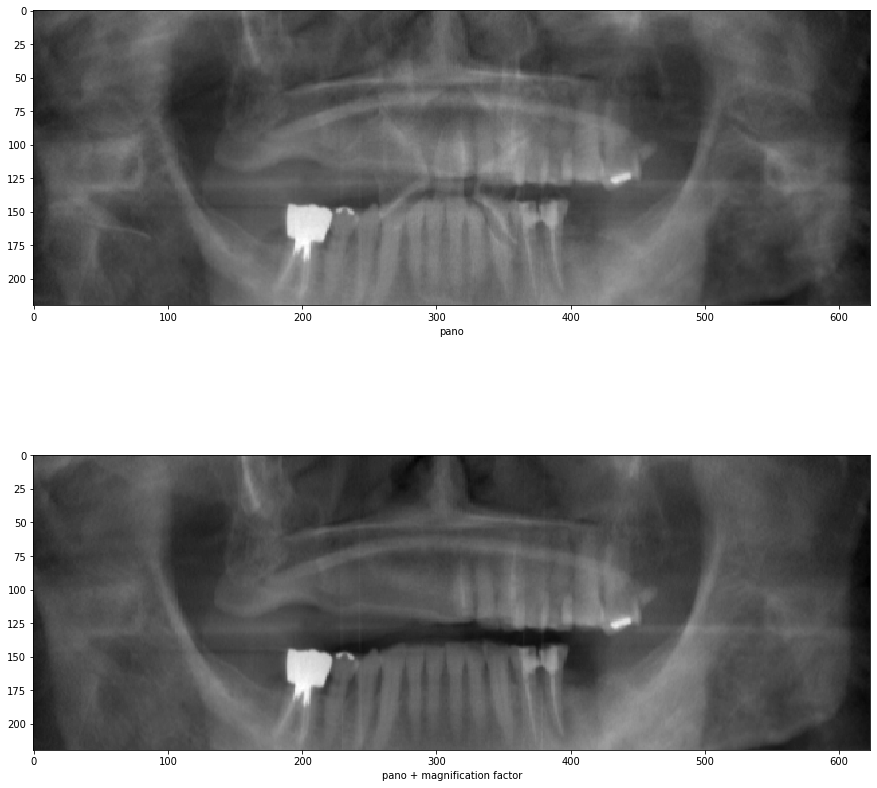

In [42]:
## plot projected 2d ct image (1) and projected 2d ct image with parabola function (2)
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.xlabel('pano')
plt.imshow(np.rot90(pano, 2), cmap='gray')

plt.subplot(212)
plt.xlabel('pano + magnification factor')
plt.imshow(np.rot90(w_pano, 2), cmap='gray')

In [37]:
devide = 1000 # 나누는 비율 
for w in range(sample.shape[0]):
    weighted_sample[w] = sample[w]*(1-(w/devide)) 

1.0
0.999
0.998
0.997
0.996
0.995
0.994
0.993
0.992
0.991
0.99
0.989
0.988
0.987
0.986
0.985
0.984
0.983
0.982
0.981
0.98
0.979
0.978
0.977
0.976
0.975
0.974
0.973
0.972
0.971
0.97
0.969
0.968
0.967
0.966
0.965
0.964
0.963
0.962
0.961
0.96
0.959
0.958
0.957
0.956
0.955
0.954
0.953
0.952
0.951
0.95
0.949
0.948
0.947
0.946
0.945
0.944
0.943
0.942
0.9410000000000001
0.94
0.9390000000000001
0.938
0.937
0.9359999999999999
0.935
0.9339999999999999
0.933
0.9319999999999999
0.931
0.9299999999999999
0.929
0.928
0.927
0.926
0.925
0.924
0.923
0.922
0.921
0.92
0.919
0.918
0.917
0.916
0.915
0.914
0.913
0.912
0.911
0.91
0.909
0.908
0.907
0.906
0.905
0.904
0.903
0.902
0.901
0.9
0.899
0.898
0.897
0.896
0.895
0.894
0.893
0.892
0.891
0.89
0.889
0.888
0.887
0.886
0.885
0.884
0.883
0.882
0.881
0.88
0.879
0.878
0.877
0.876
0.875
0.874
0.873
0.872
0.871
0.87
0.869
0.868
0.867
0.866
0.865
0.864
0.863
0.862
0.861
0.86
0.859
0.858
0.857
0.856
0.855
0.854
0.853
0.852
0.851
0.85
0.849
0.848
0.847
0.846
0.845
0.8

</br>

# sample test

In [5]:
p=150
q=round(math.sqrt(-(p-c)/a)+b) # 600
delta_x = 1
delta_y = 0
# devide = 1000 
# devide = sample.shape[0] 
w_img_pano1 = []
w_img_pano2 = []
w_img_pano3 = []

i=1

while (p <= c) and (delta_x >= delta_y) :
    loop_starts = time.time()
#     if p <= c and delta_x >= delta_y:
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
    
    # rotate 3d
    ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
    sample = ct_vol[:, indx[0][0], :]

    # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
    weighted_sample1 = np.zeros((sample.shape[0], sample.shape[1]))
    weighted_sample2 = np.zeros((sample.shape[0], sample.shape[1]))
    weighted_sample3 = np.zeros((sample.shape[0], sample.shape[1]))
        
    for w in range(sample.shape[0]):
        weighted_sample1[w] = sample[w]*(1-(w/671)) 
        weighted_sample2[w] = sample[w]*(1-(w/1000)) 
        weighted_sample3[w] = sample[w]*(1-(w/2000)) 

    w_sum1 = np.sum(weighted_sample1, axis=0) # add magnification factor
    w_sum2 = np.sum(weighted_sample2, axis=0)
    w_sum3 = np.sum(weighted_sample3, axis=0)     
        
    w_img_pano1.append(np.reshape(w_sum1, (ct_vol.shape[2], 1)))
    w_img_pano2.append(np.reshape(w_sum2, (ct_vol.shape[2], 1)))
    w_img_pano3.append(np.reshape(w_sum3, (ct_vol.shape[2], 1)))

    prev_p=p
    prev_q=q
    p=p+1
    q=round(math.sqrt(-(p-c)/a)+b)
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    p_indx = indx[0][0]

    print(i, 'angle : ', angle)
    print('1번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    
    i+=1
    if i <= 10 : 
        now = time.time()
        print("Takes {0} seconds for 1 loop".format(now - loop_starts))
        
    print('==========================================')

while (q>=b):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)
    
    if g != 0:
        tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
        tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
        rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
        sum_rot_tmp = np.sum(rot_tmp, axis=0)
        indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
        
        if indx[0][0] > p_indx + 10 :
            indx[0][0] = p_indx 

        ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
        sample = ct_vol[:, indx[0][0], :]
        
        # magnification factor 0~500 pixel = 0 ~ 1 
        weighted_sample1 = np.zeros((sample.shape[0], sample.shape[1]))
        weighted_sample2 = np.zeros((sample.shape[0], sample.shape[1]))
        weighted_sample3 = np.zeros((sample.shape[0], sample.shape[1]))
        
        for w in range(sample.shape[0]):
            weighted_sample1[w] = sample[w]*(1-(w/671)) 
            weighted_sample2[w] = sample[w]*(1-(w/1000)) 
            weighted_sample3[w] = sample[w]*(1-(w/2000)) 

        w_sum1 = np.sum(weighted_sample1, axis=0) # add magnification factor
        w_sum2 = np.sum(weighted_sample2, axis=0)
        w_sum3 = np.sum(weighted_sample3, axis=0)     
        
        w_img_pano1.append(np.reshape(w_sum1, (ct_vol.shape[2], 1)))
        w_img_pano2.append(np.reshape(w_sum2, (ct_vol.shape[2], 1)))
        w_img_pano3.append(np.reshape(w_sum3, (ct_vol.shape[2], 1)))
        
    else:
        print(angle, ' (degree)')
        tmp = abs((y-q)) ### 90도 일때 , 법선을 따로 구해줘야함. 
        tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)  
        rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False)
        sum_rot_tmp = np.sum(rot_tmp, axis=0)
        indx = np.where(sum_rot_tmp == sum_rot_tmp.max())

        ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
        sample = ct_vol[:, indx[0][0], :]
        
        # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
        weighted_sample1 = np.zeros((sample.shape[0], sample.shape[1]))
        weighted_sample2 = np.zeros((sample.shape[0], sample.shape[1]))
        weighted_sample3 = np.zeros((sample.shape[0], sample.shape[1]))
        
        for w in range(sample.shape[0]):
            weighted_sample1[w] = sample[w]*(1-(w/671)) 
            weighted_sample2[w] = sample[w]*(1-(w/1000)) 
            weighted_sample3[w] = sample[w]*(1-(w/2000)) 

        w_sum1 = np.sum(weighted_sample1, axis=0) # add magnification factor
        w_sum2 = np.sum(weighted_sample2, axis=0)
        w_sum3 = np.sum(weighted_sample3, axis=0)     
        
        w_img_pano1.append(np.reshape(w_sum1, (ct_vol.shape[2], 1)))
        w_img_pano2.append(np.reshape(w_sum2, (ct_vol.shape[2], 1)))
        w_img_pano3.append(np.reshape(w_sum3, (ct_vol.shape[2], 1)))
    
    prev_p=p
    prev_q=q
    q=q-1
    p=(-a)*(q-b)**2+c
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    p_indx = indx[0][0]
    
    print(i, 'angle : ', angle)
    print('2번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    print('==========================================')
    i=i+1
    
while (q>=150) and (delta_x<=delta_y):    
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())
    
    if indx[0][0] > p_indx + 10 :
        indx[0][0] = p_indx 

    ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
    sample = ct_vol[:, indx[0][0], :]

    # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
    weighted_sample1 = np.zeros((sample.shape[0], sample.shape[1]))
    weighted_sample2 = np.zeros((sample.shape[0], sample.shape[1]))
    weighted_sample3 = np.zeros((sample.shape[0], sample.shape[1]))

    for w in range(sample.shape[0]):
        weighted_sample1[w] = sample[w]*(1-(w/671)) 
        weighted_sample2[w] = sample[w]*(1-(w/1000)) 
        weighted_sample3[w] = sample[w]*(1-(w/2000)) 

    w_sum1 = np.sum(weighted_sample1, axis=0) # add magnification factor
    w_sum2 = np.sum(weighted_sample2, axis=0)
    w_sum3 = np.sum(weighted_sample3, axis=0)     

    w_img_pano1.append(np.reshape(w_sum1, (ct_vol.shape[2], 1)))
    w_img_pano2.append(np.reshape(w_sum2, (ct_vol.shape[2], 1)))
    w_img_pano3.append(np.reshape(w_sum3, (ct_vol.shape[2], 1)))
    
    prev_p=p
    prev_q=q
    q=q-1
    p=-a*(q-b)**2+c
    delta_x=abs(p-prev_p)
    delta_y=abs(q-prev_q)
    
    print(i, 'angle : ', angle)
    print('3번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    print('==========================================')
    i=i+1
    
while (p>=150):
    g=(-2*a*(q-b)) # 접선의 기울기 
    angle = -180*(math.atan2(-1,g)/math.pi)

    tmp = abs((-1./g)*(y-q)+p-x) # 법선의 방정식 (기울기 (접선)x(법선) = -1)
    tmp_r = np.where(tmp < 1, tmp_.max() , tmp_)
    rot_tmp = rot3d(tmp_r, angle, axes=(1,0), reshape=False) # 180*(math.atan2(-1,g)/math.pi) is same as matlab atan2d function
    sum_rot_tmp = np.sum(rot_tmp, axis=0)
    indx = np.where(sum_rot_tmp == sum_rot_tmp.max())

    ct_vol = rot3d(sam_, angle, axes=(1,0), reshape=False)
    sample = ct_vol[:, indx[0][0], :]

    # magnification factor 0~500 pixel = 0.002 ~ 1 / 500~pixel = 1
    weighted_sample1 = np.zeros((sample.shape[0], sample.shape[1]))
    weighted_sample2 = np.zeros((sample.shape[0], sample.shape[1]))
    weighted_sample3 = np.zeros((sample.shape[0], sample.shape[1]))
        
    for w in range(sample.shape[0]):
        weighted_sample1[w] = sample[w]*(1-(w/671)) 
        weighted_sample2[w] = sample[w]*(1-(w/1000)) 
        weighted_sample3[w] = sample[w]*(1-(w/2000)) 

    w_sum1 = np.sum(weighted_sample1, axis=0) # add magnification factor
    w_sum2 = np.sum(weighted_sample2, axis=0)
    w_sum3 = np.sum(weighted_sample3, axis=0)     
        
    w_img_pano1.append(np.reshape(w_sum1, (ct_vol.shape[2], 1)))
    w_img_pano2.append(np.reshape(w_sum2, (ct_vol.shape[2], 1)))
    w_img_pano3.append(np.reshape(w_sum3, (ct_vol.shape[2], 1))) 
    
    prev_p=p
    prev_q=q
    p=p-1 
#     q=round(math.sqrt(-(p-c)/a)+b) ->  q=round(-math.sqrt(-(p-c)/a)+b) 그래프가 뒤집어 져야함. (수정)
    q=round(-math.sqrt(-(p-c)/a)+b)

    print(i, 'angle : ', angle)
    print('4번 조건문')
    print('prev_p : ', prev_p, 'prev_q : ', prev_q)
    print('delta x and delta y : ', delta_x , delta_y)
    print('==========================================')
    i=i+1

    
now = time.time()
print("Total loop : ",(now - program_starts)/60, " min")

1 angle :  153.43494882292202
1번 조건문
prev_p :  150 prev_q :  600
delta x and delta y :  1 1
Takes 11.383304595947266 seconds for 1 loop
2 angle :  153.34298135854587
1번 조건문
prev_p :  151 prev_q :  599
delta x and delta y :  1 0
Takes 11.463018655776978 seconds for 1 loop
3 angle :  153.34298135854587
1번 조건문
prev_p :  152 prev_q :  599
delta x and delta y :  1 1
Takes 11.427595853805542 seconds for 1 loop
4 angle :  153.2504219906605
1번 조건문
prev_p :  153 prev_q :  598
delta x and delta y :  1 0
Takes 11.366884231567383 seconds for 1 loop
5 angle :  153.2504219906605
1번 조건문
prev_p :  154 prev_q :  598
delta x and delta y :  1 1
Takes 11.344351053237915 seconds for 1 loop
6 angle :  153.1572654743793
1번 조건문
prev_p :  155 prev_q :  597
delta x and delta y :  1 0
Takes 11.310623168945312 seconds for 1 loop
7 angle :  153.1572654743793
1번 조건문
prev_p :  156 prev_q :  597
delta x and delta y :  1 1
Takes 11.262717008590698 seconds for 1 loop
8 angle :  153.06350650955122
1번 조건문
prev_p :  157 p

NameError: name 'program_starts' is not defined

In [6]:
pano1 = w_img_pano1[0]
pano2 = w_img_pano2[0]
pano3 = w_img_pano3[0]

for i in range(len(w_img_pano1)-1): # 
    pano1 = np.concatenate((pano1, w_img_pano1[i+1]), axis= 1)
    pano2 = np.concatenate((pano2, w_img_pano2[i+1]), axis= 1)
    pano3 = np.concatenate((pano3, w_img_pano3[i+1]), axis= 1)

print(pano1.shape)
print(pano2.shape)
print(pano3.shape)

(220, 624)
(220, 624)
(220, 624)


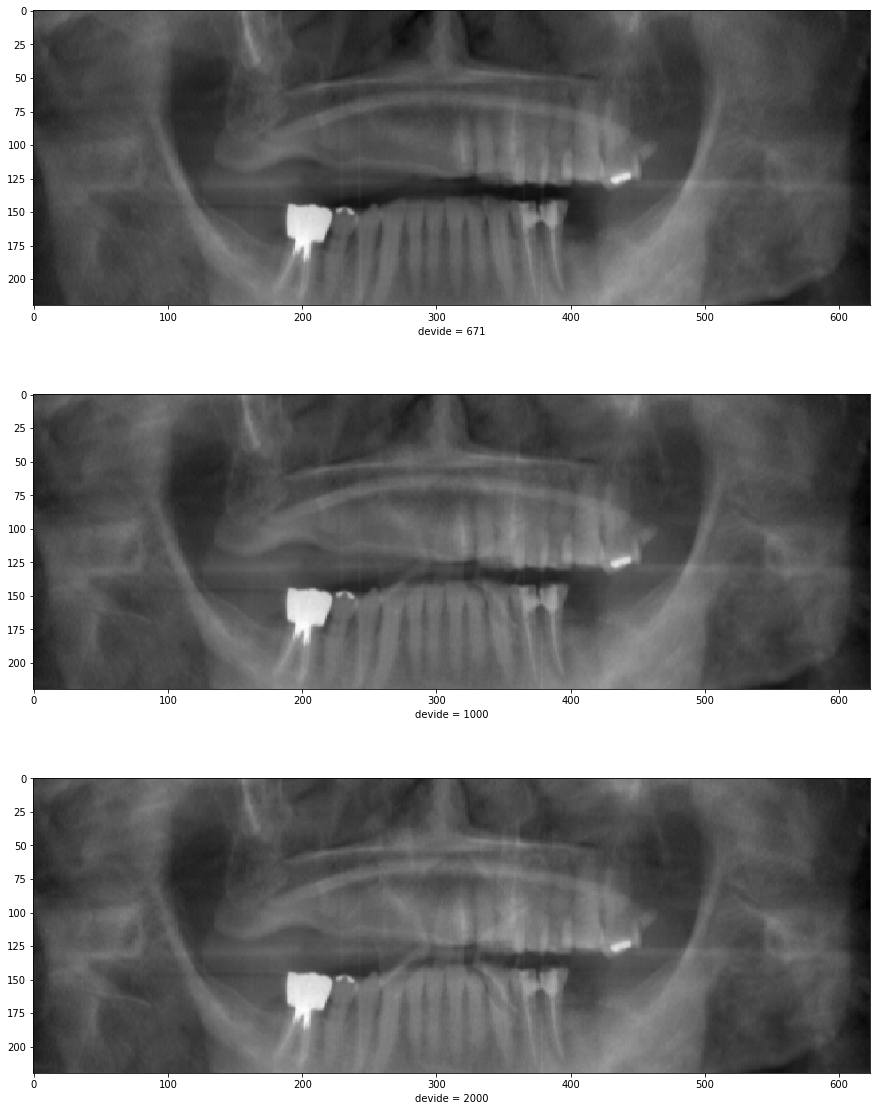

In [10]:
plt.figure(figsize=(15,20))
plt.subplot(311)
plt.xlabel('devide = 671')
plt.imshow(np.rot90(pano1, 2), cmap='gray')

plt.subplot(312)
plt.xlabel('devide = 1000')
plt.imshow(np.rot90(pano2, 2), cmap='gray')

plt.subplot(313)
plt.xlabel('devide = 2000')
plt.imshow(np.rot90(pano3, 2), cmap='gray')

In [9]:
for w in range(sample.shape[0]):
    if w == 0 or w > 668:
        print(w, 1-(w/671)) 
        print(w, 1-(w/1000)) 
        print(w, 1-(w/2000))
        print('-------------')

0 1.0
0 1.0
0 1.0
-------------
669 0.0029806259314456574
669 0.33099999999999996
669 0.6655
-------------
670 0.0014903129657227732
670 0.32999999999999996
670 0.665
-------------
